In [159]:
import pandas as pd
import numpy as np

pd.options.plotting.backend = "plotly"
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots



import plotly.io as pio
import plotly.express as px

pio.templates.default = "simple_white"

In [160]:
control_columns = [
    "Participant id",
    "Number of subordinates",
    "Age",
    "Sex",
]

data_usa_raw = pd.read_csv("../data/raw/usa/all_apps_wide_2023-11-14_USA.csv").merge(
    pd.read_csv("../data/raw/usa/prolific_demographics.csv")[control_columns],
    left_on="participant.label",
    right_on="Participant id",
    how="left",
)
data_deu_1_raw = pd.read_csv(
    "../data/raw/deutsch/all_apps_wide_2023-11-14_DEU.csv"
).merge(
    pd.read_csv("../data/raw/deutsch/prolific_demographics.csv")[control_columns],
    left_on="participant.label",
    right_on="Participant id",
    how="left",
)


data_deu_2_raw = (
    pd.read_csv("../data/raw/deutsch runde 2/all_apps_wide_2023-11-16_DEU.csv")
    .merge(
        pd.read_csv("../data/raw/deutsch runde 2/prolific_demographics.csv")[
            control_columns
        ],
        left_on="participant.label",
        right_on="Participant id",
        how="left",
    )
)

In [161]:
# page times

page_times_usa_raw = pd.read_csv("../data/raw/usa/PageTimes-2023-11-14_USA.csv")
page_times_deu_1_raw = pd.read_csv("../data/raw/deutsch/PageTimes-2023-11-14_DEU.csv")


page_times_deu_2_raw = pd.read_csv(
    "../data/raw/deutsch runde 2/PageTimes-2023-11-16_DEU.csv"
)

In [162]:
merged_times = pd.concat(
    [page_times_usa_raw, page_times_deu_1_raw, page_times_deu_2_raw], axis=0
)

time_delta = (
    (
        merged_times.groupby("participant_code")["epoch_time_completed"].max()
        - merged_times.groupby("participant_code")["epoch_time_completed"].min()
    )
    .to_frame()
    .reset_index()
)

In [217]:
relevant_columns = [
    "survey.1.player.positive_szenarios",
    "survey.1.player.treatment_pa",
    "survey.1.player.PRS1T1",
    "survey.1.player.PRS1T2",
    "survey.1.player.PRS2T1",
    "survey.1.player.PRS2T2",
    "survey.1.player.PRS3T1",
    "survey.1.player.PRS3T2",
    "survey.1.player.PRS4T1",
    "survey.1.player.PRS4T2",
    "survey.1.player.FRS1T1",
    "survey.1.player.FRS1T2",
    "survey.1.player.FRS2T1",
    "survey.1.player.FRS2T2",
    "survey.1.player.FRS3T1",
    "survey.1.player.FRS3T2",
    "survey.1.player.FRS4T1",
    "survey.1.player.FRS4T2",
    "survey.1.player.ARS1T1",
    "survey.1.player.ARS1T2",
    "survey.1.player.ARS2T1",
    "survey.1.player.ARS2T2",
    "survey.1.player.ARS3T1",
    "survey.1.player.ARS3T2",
    "survey.1.player.ARS4T1",
    "survey.1.player.ARS4T2",
    "survey.1.player.ETHS1T1",
    "survey.1.player.ETHS1T2",
    "survey.1.player.ETHS2T1",
    "survey.1.player.ETHS2T2",
    "survey.1.player.ETHS3T1",
    "survey.1.player.ETHS3T2",
    "survey.1.player.ETHS4T1",
    "survey.1.player.ETHS4T2",
    "survey.1.player.PROS1T1",
    "survey.1.player.PROS1T2",
    "survey.1.player.PROS2T1",
    "survey.1.player.PROS2T2",
    "survey.1.player.PROS3T1",
    "survey.1.player.PROS3T2",
    "survey.1.player.PROS4T1",
    "survey.1.player.PROS4T2",
    "survey.1.player.algo_aversion",
    "survey.1.player.risk_propensity",
    "origin",
    "overall_time",
    "Number of subordinates",
    "Age",
    "Sex",
    "participant.label",
]

In [218]:
data_all = (
    pd.concat(
        [
            data_usa_raw.assign(origin="USA"),
            data_deu_1_raw.assign(origin="DEU"),
            data_deu_2_raw.assign(origin="DEU"),
        ],
        axis=0,
    )
    .merge(time_delta, left_on="participant.code", right_on="participant_code")
    .rename(columns={"epoch_time_completed": "overall_time"})
    .loc[lambda df_: df_["participant._current_page_name"] == "End"]
    .loc[:, relevant_columns]
    .rename(
        columns=dict(
            zip(
                relevant_columns,
                [x.replace("survey.1.player.", "") for x in relevant_columns],
            )
        )
    )
    .rename(
        columns={
            "Number of subordinates": "number_of_subordinates",
            "Age": "age",
            "Sex": "sex",
        }
    )
    .assign(
        sex=lambda df_: df_.sex.replace("Female", 1).replace("Male", 0),
        number_of_subordinates=lambda df_: df_.number_of_subordinates.replace(
            {"2-3": 0, "4-6": 1, "7-10": 2, ">10": 3}
        ),
        # TODO NEXT Check how to replace here by dict values  !!
    )
)
MIN_TIME = data_all.overall_time.quantile(0.25)  # 5 min also worked ok
MAX_TIME = data_all.overall_time.quantile(0.75)  # 15 also min worked ok
data_all = (
    data_all
    .loc[
    data_all.overall_time.between(left=MIN_TIME, right=MAX_TIME, inclusive="both")]
    .loc[
    data_all.age != "DATA_EXPIRED"
].astype({"sex": "int", "age": "int", "number_of_subordinates": "int"})
)
data_usa = data_all.loc[data_all.origin == "USA"]
data_deu = data_all.loc[data_all.origin == "DEU"]

Scale explanation:
- FRS1T1 -->  feel responsible senario 1, team lead 1 (familiar solution)
- ARS1T1 -->  act responsible senario 1, team lead 1 (familiar solution)
- FRS1T2 -->  feel responsible senario 1, team lead 2 (new solution)
- ARS1T2 -->  act responsible senario 1, team lead 2 (new solution)

In [219]:
scenario_dict_outcome = {
    "1": {"positive": "1_and_4", "negative": "2_and_3"},
    "2": {"positive": "2_and_3", "negative": "1_and_4"},
    "3": {"positive": "2_and_3", "negative": "1_and_4"},
    "4": {"positive": "1_and_4", "negative": "2_and_3"},
}

scenario_dict_pa = {
    "1": {"yes": "1_and_4", "no": "2_and_3"},
    "2": {"yes": "2_and_3", "no": "1_and_4"},
    "3": {"yes": "2_and_3", "no": "1_and_4"},
    "4": {"yes": "1_and_4", "no": "2_and_3"},
}


def get_mean_scales(data, scale, scenario_nr, solution_type, outcome, pa):
    scale_string = ""
    if scale == "feel":
        scale_string += "FR"
    elif scale == "act":
        scale_string += "AR"
    elif scale == "risk":
        scale_string += "PR"

    scale_string += f"S{scenario_nr}"

    if solution_type == "familiar":
        scale_string += "T1"
    else:
        scale_string += "T2"

    outcome_filter = scenario_dict_outcome[str(scenario_nr)][outcome]
    pa_filter = scenario_dict_pa[str(scenario_nr)][pa]

    return data.loc[
        (data.positive_szenarios == outcome_filter)
        & (data.treatment_pa == pa_filter),
        scale_string,
    ].mean()

## Plot Fig 1 from Nordbye

In [220]:
x_axis_values_list = [
    ["Familiar solution", "New solution"],
    ["Follow advise", "Not follow advise"],
    ["Hold on", "Change decision"],
    ["Wait and see", "Take action"],
]

d3_colors = px.colors.qualitative.D3
colors_dict = {
    "feel responsible + positive outcome + PA yes": d3_colors[0],
    "feel responsible + positive outcome + PA no": d3_colors[1],
    "feel responsible + negative outcome + PA yes": d3_colors[2],
    "feel responsible + negative outcome + PA no": d3_colors[3],
    "act responsible + positive outcome + PA yes": d3_colors[4],
    "act responsible + positive outcome + PA no": d3_colors[5],
    "act responsible + negative outcome + PA yes": d3_colors[6],
    "act responsible + negative outcome + PA no": d3_colors[7],
}


def create_line_subplot(data, output_file_name, show_fig, fig_title):
    fig = make_subplots(rows=2, cols=2)

    for scenario, x_axis_values in zip(range(1, 5), x_axis_values_list):
        for responsibility_scale in ["feel", "act"]:
            for outcome in ["positive", "negative"]:
                for pa_available in ["yes", "no"]:
                    fig.add_trace(
                        go.Scatter(
                            x=x_axis_values,
                            y=[
                                get_mean_scales(
                                    data=data,
                                    scale=responsibility_scale,
                                    scenario_nr=scenario,
                                    solution_type="familiar",
                                    outcome=outcome,
                                    pa=pa_available,
                                ),
                                get_mean_scales(
                                    data=data,
                                    scale=responsibility_scale,
                                    scenario_nr=scenario,
                                    solution_type="new",
                                    outcome=outcome,
                                    pa=pa_available,
                                ),
                            ],
                            mode="lines+markers",
                            name=f"{responsibility_scale} responsible + {outcome} outcome + PA {pa_available}",
                            legendgroup=f"{responsibility_scale} responsible + {outcome} outcome + PA {pa_available}",
                            marker_color=colors_dict[
                                f"{responsibility_scale} responsible + {outcome} outcome + PA {pa_available}"
                            ],
                            showlegend=True if scenario == 1 else False,
                        ),
                        row=1 if scenario in [1, 2] else 2,
                        col=1 if scenario in [1, 3] else 2,
                    )
    fig.update_yaxes(range=[1, 7], dtick=1)
    fig.update_layout(width=900 + 200, height=600 + 200, title=fig_title)
    fig.write_html(f"{output_file_name}.html")
    if show_fig:
        fig.show()

In [221]:
create_line_subplot(data=data_all, output_file_name="scenarios_all", show_fig=True, fig_title="All")

In [222]:
create_line_subplot(
    data=data_deu, output_file_name="scenarios_deu", show_fig=True, fig_title="DEU"
)

In [223]:
create_line_subplot(
    data=data_usa, output_file_name="scenarios_usa", show_fig=True, fig_title="USA"
)

## who is perceied to feel / act more responsible?

In [224]:
# who is perceied to feel more responsible?
t1_columns_feel = [f"FRS{x}T1" for x in range(1, 5)]
t2_columns_feel = [f"FRS{x}T2" for x in range(1, 5)]

# who is perceied to act more responsible?
t1_columns_act = [f"ARS{x}T1" for x in range(1, 5)]
t2_columns_act = [f"ARS{x}T2" for x in range(1, 5)]

pd.DataFrame(
    {
        "t1_feel": data_all[t1_columns_feel].to_numpy().reshape(-1),
        "t2_feel": data_all[t2_columns_feel].to_numpy().reshape(-1),
        "t1_act": data_all[t1_columns_act].to_numpy().reshape(-1),
        "t2_act": data_all[t2_columns_act].to_numpy().reshape(-1),
    }
).describe()

,t1_feel,t2_feel,t1_act,t2_act
count,360.000000,360.000000,360.000000,360.000000
mean,4.713889,5.988889,5.130556,4.708333
std,1.814159,1.242196,1.587612,1.567759
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,5.000000,4.000000,4.000000
50%,5.000000,6.000000,6.000000,5.000000
75%,6.000000,7.000000,6.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000


--> t2 (B) will feel more responsible and acted less responsible

## Regression

In [225]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [226]:
data_all.columns

Index(['positive_szenarios', 'treatment_pa', 'PRS1T1', 'PRS1T2', 'PRS2T1',
       'PRS2T2', 'PRS3T1', 'PRS3T2', 'PRS4T1', 'PRS4T2', 'FRS1T1', 'FRS1T2',
       'FRS2T1', 'FRS2T2', 'FRS3T1', 'FRS3T2', 'FRS4T1', 'FRS4T2', 'ARS1T1',
       'ARS1T2', 'ARS2T1', 'ARS2T2', 'ARS3T1', 'ARS3T2', 'ARS4T1', 'ARS4T2',
       'ETHS1T1', 'ETHS1T2', 'ETHS2T1', 'ETHS2T2', 'ETHS3T1', 'ETHS3T2',
       'ETHS4T1', 'ETHS4T2', 'PROS1T1', 'PROS1T2', 'PROS2T1', 'PROS2T2',
       'PROS3T1', 'PROS3T2', 'PROS4T1', 'PROS4T2', 'algo_aversion',
       'risk_propensity', 'origin', 'overall_time', 'number_of_subordinates',
       'age', 'sex', 'participant.label'],
      dtype='object')

In [230]:
def get_regression_df(szenario_nr, dependent_variable):
    t1_df = (
        data_all[
            [
                "positive_szenarios",
                "treatment_pa",
                "algo_aversion",
                "number_of_subordinates",
                "age",
                "sex",
                f"{dependent_variable}S{szenario_nr}T1",
            ]
        ]
        .assign(
            outcome_positive=data_all.positive_szenarios.replace(
                scenario_dict_outcome[str(szenario_nr)]["positive"], 1
            ).replace(scenario_dict_outcome[str(szenario_nr)]["negative"], 0),
            pa_available=data_all.treatment_pa.replace(
                scenario_dict_pa[str(szenario_nr)]["yes"], 1
            ).replace(scenario_dict_pa[str(szenario_nr)]["no"], 0),
            participant=range(data_all.shape[0]),
            active_teamlead=1,
            origin_usa=data_all.origin == "USA",
        )
        .rename(columns={f"{dependent_variable}S{szenario_nr}T1": dependent_variable})
        .astype({"origin_usa": "int"})
    )

    t2_df = (
        data_all[
            [
                "positive_szenarios",
                "treatment_pa",
                "algo_aversion",
                "number_of_subordinates",
                "age",
                "sex",
                f"{dependent_variable}S{szenario_nr}T2",
            ]
        ]
        .assign(
            outcome_positive=data_all.positive_szenarios.replace(
                scenario_dict_outcome[str(szenario_nr)]["positive"], 1
            ).replace(scenario_dict_outcome[str(szenario_nr)]["negative"], 0),
            pa_available=data_all.treatment_pa.replace(
                scenario_dict_pa[str(szenario_nr)]["yes"], 1
            ).replace(scenario_dict_pa[str(szenario_nr)]["no"], 0),
            participant=range(data_all.shape[0]),
            active_teamlead=0,
            origin_usa=data_all.origin == "USA",
        )
        .rename(columns={f"{dependent_variable}S{szenario_nr}T2": dependent_variable})
        .astype({"origin_usa": "int"})
    )

    return pd.concat([t1_df, t2_df], axis=0).loc[
        :,
        [
            dependent_variable,
            "outcome_positive",
            "pa_available",
            "active_teamlead",
            "participant",
            "algo_aversion",
            "origin_usa",
            "number_of_subordinates",
            "age",
            "sex",
        ],
    ]

In [313]:
def get_PR_residuals():
    dependent_variable = "PR"
    regression_df_all = pd.DataFrame()
    for scenario in range(1, 5):
        regression_df = get_regression_df(scenario, dependent_variable)
        regression_df = regression_df.assign(scenario=scenario)
        regression_df_all = pd.concat([regression_df_all, regression_df])

    mod = smf.ols(
        formula=f"{dependent_variable} ~ C(scenario) + sex + algo_aversion + origin_usa",
        data=regression_df_all,
    )
    res = mod.fit()
    res.summary()  # .tables[1]
    # if (
    #     min(
    #         res.pvalues["pa_available"],
    #         res.pvalues["pa_available:active_teamlead"],
    #     )
    #     < 0.05
    # ):
    #     print(f"{scenario=}, {dependent_variable=}")
    #     print(res.summary().tables[1])
    #     print(20 * "-")

    return list(res.resid)

In [312]:
dependent_variable = "PR"
regression_df_all = pd.DataFrame()
for scenario in range(1, 5):
    regression_df = get_regression_df(scenario, dependent_variable)
    regression_df = regression_df.assign(scenario=scenario)
    regression_df_all = pd.concat([regression_df_all, regression_df])

mod = smf.ols(
    formula=f"{dependent_variable} ~ C(scenario) + sex + algo_aversion + origin_usa",
    data=regression_df_all,
)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PR   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.651
Date:                Fri, 17 Nov 2023   Prob (F-statistic):            0.00141
Time:                        17:47:09   Log-Likelihood:                -1453.9
No. Observations:                 720   AIC:                             2922.
Df Residuals:                     713   BIC:                             2954.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.4448      0.318     10.827      0.000       2.820       4.069
C(scenario)[T.2]     0.3278      0.193      1.698      0.090      -0.051       0.707
C(scenario)[T.3]     0.3778      0.193      1.956      0.051      -0.001       0.757
C(scenario)[T.4]     0.8556      0.193      4.431      0.000       0.476       1.235
sex                  0.0988      0.156      0.633      0.527      -0.208       0.405
algo_aversion        0.0654      0.057      1.143      0.253      -0.047       0.178
origin_usa          -0.0652      0.140     -0.466      0.642      -0.340       0.210
==============================================================================
Omnibus:                      208.096   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.196
Skew:                          -0.236   Prob(JB):                     1.87e-09
Kurtosis:                       1.944   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [314]:
regresion_results = []
for dependent_variable in ["AR", "FR"]:
    regression_df_all = pd.DataFrame()
    for scenario in range(1, 5):
        regression_df = get_regression_df(scenario, dependent_variable)
        regression_df = regression_df.assign(scenario=scenario)
        regression_df_all = pd.concat([regression_df_all, regression_df])

    regression_df_all = regression_df_all.assign(residuals_PR=get_PR_residuals())

    mod = smf.mixedlm(
        formula=f"{dependent_variable} ~ C(scenario) + outcome_positive * pa_available * active_teamlead + residuals_PR + algo_aversion + sex + origin_usa",
        groups="participant",
        data=regression_df_all,
    )

    regresion_results.append(mod.fit())
    print(f"AIC: {mod.fit(reml=False).aic}")

# if (
#     min(
#         res.pvalues["pa_available"],
#         res.pvalues["outcome_positive:pa_available"],
#         res.pvalues["outcome_positive:pa_available:active_teamlead"],
#     )
#     < 0.05
# ):
#     print(f"{scenario=}, {dependent_variable=}")
#     print(res.summary().tables[1])
#     print(20 * "-")

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/mode

AIC: 2526.616964634696


/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning:

Retrying MixedLM optimization with cg

/Users/david/Documents/CodeProjects/pa-leadership-survey/analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.p

AIC: 2602.138616357355


In [319]:
regresion_results[1].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                        MixedLM           Dependent Variable:           FR        
No. Observations:             720               Method:                       REML      
No. Groups:                   90                Scale:                        1.9627    
Min. group size:              8                 Log-Likelihood:               -1283.5014
Max. group size:              8                 Converged:                    No        
Mean group size:              8.0                                                       
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      5.421    0.348 15.597 0.000  4.740  6.102
C(scenario)[T.2]                              -0.483    0.148 -3.256 0.001 -0.774 -0.192
C(scenario)[T.3]                               0.195    0.148  1.312 0.189 -0.096  0.485
C(scenario)[T.4]                              -0.094    0.148 -0.640 0.522 -0.384  0.195
outcome_positive                               0.038    0.230  0.167 0.867 -0.412  0.489
pa_available                                  -0.426    0.231 -1.845 0.065 -0.879  0.026
outcome_positive:pa_available                  0.559    0.353  1.584 0.113 -0.133  1.250
active_teamlead                               -1.536    0.217 -7.085 0.000 -1.961 -1.111
outcome_positive:active_teamlead               1.094    0.296  3.702 0.000  0.515  1.673
pa_available:active_teamlead                   0.725    0.297  2.443 0.015  0.143  1.307
outcome_positive:pa_available:active_teamlead -1.335    0.419 -3.184 0.001 -2.157 -0.513
residuals_PR                                   0.159    0.035  4.540 0.000  0.091  0.228
algo_aversion                                  0.073    0.059  1.241 0.215 -0.042  0.189
sex                                            0.355    0.162  2.198 0.028  0.039  0.672
origin_usa                                     0.168    0.144  1.167 0.243 -0.114  0.451
participant Var                                0.199    0.045                           
========================================================================================

"""

In [315]:
# Zuerst kommen die Treatment variables (Intercept, PA, Outcome, dann die Interaktion PA*Outcome, dann die Kontrollvariablen wie algo aversion, dann die soziodemographischen Kontrollvariablen, participant-level FE bitte noch mal nachschauen, wie die korrekt zu reporten sind, meiner Meinung nicht als IVs im regression table. 
                                       
covariates_order =[
    "Intercept",
    "outcome_positive",
    "pa_available",
    "active_teamlead",
    "outcome_positive:pa_available",
    "pa_available:active_teamlead",
    "outcome_positive:active_teamlead",
    "outcome_positive:pa_available:active_teamlead",
    "residuals_PR",
    "algo_aversion",
    "origin_usa",
    "sex",
    "C(scenario)[T.2]",
    "C(scenario)[T.3]",
    "C(scenario)[T.4]",
]

In [316]:
stargazer = Stargazer(regresion_results)
stargazer.covariate_order(covariates_order)

with open("reg_tables_new.html", "w") as outfile:
    outfile.write(stargazer.render_html())

In [ ]:
all_regression_df_feel_responsible = pd.DataFrame()
for scenario in range(1, 5):
    for dependent_variable in ["FR"]:
        regression_df = get_regression_df(scenario, dependent_variable)
        regression_df = regression_df.assign(vignette=scenario)
        all_regression_df_feel_responsible = pd.concat(
            [all_regression_df_feel_responsible, regression_df]
        )

In [ ]:
all_regression_df_act_responsible = pd.DataFrame()
for scenario in range(1, 5):
    for dependent_variable in ["AR"]:
        regression_df = get_regression_df(scenario, dependent_variable)
        regression_df = regression_df.assign(vignette=scenario)
        all_regression_df_act_responsible = pd.concat(
            [all_regression_df_act_responsible, regression_df]
        )

In [ ]:
all_regression_df_perceived_risk = pd.DataFrame()
for scenario in range(1, 5):
    for dependent_variable in ["PR"]:
        regression_df = get_regression_df(scenario, dependent_variable)
        regression_df = regression_df.assign(vignette=scenario)
        all_regression_df_perceived_risk = pd.concat(
            [all_regression_df_perceived_risk, regression_df]
        )

In [ ]:
all_regression_df_feel_responsible.to_csv(
    "regressions_df_feel_responsible.csv", index=False
)
all_regression_df_act_responsible.to_csv("regression_df_act_responsible.csv", index=False)
all_regression_df_perceived_risk.to_csv("regression_df_perceived_risk.csv", index=False)

In [ ]:
all_regression_df_feel_responsible.assign(
    AR=all_regression_df_act_responsible.AR, PR=all_regression_df_perceived_risk.PR
).loc[
    :,
    [
        "AR",
        "FR",
        "PR",
        "outcome_positive",
        "pa_available",
        "active_teamlead",
        "participant",
        "algo_aversion",
        "origin_usa",
        "number_of_subordinates",
        "age",
        "sex",
        "vignette",
    ],
].to_csv("regression_df_all_dependent_variables.csv", index=False)

## Demographics

In [ ]:
data_all[["age", "sex", "algo_aversion", "risk_propensity"]].describe().round(2)

,age,sex,algo_aversion,risk_propensity
count,90.00,90.00,90.00,90.00
mean,38.41,0.27,5.13,6.13
std,11.55,0.44,1.23,2.06
min,22.00,0.00,2.00,1.00
25%,29.25,0.00,4.00,5.00
50%,34.00,0.00,5.00,6.00
75%,46.75,1.00,6.00,7.00
max,78.00,1.00,7.00,10.00


In [ ]:
data_all.origin.value_counts(normalize=True).mul(100).round(1)

origin
USA    53.3
DEU    46.7
Name: proportion, dtype: float64

In [ ]:
data_all.overall_time.div(60).describe()

count    90.000000
mean      7.155926
std       1.654941
min       4.666667
25%       5.841667
50%       6.700000
75%       8.562500
max      10.533333
Name: overall_time, dtype: float64

In [ ]:
# how many started the survey?
pd.concat(
    [
        data_usa_raw.assign(origin="USA"),
        data_deu_1_raw.assign(origin="DEU"),
        data_deu_2_raw.assign(origin="DEU"),
    ],
    axis=0,
)["participant._current_page_name"].value_counts().sum()

213

## Marginal Effects

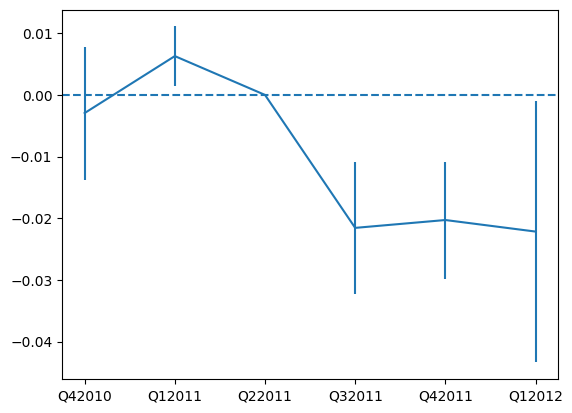

In [323]:
import matplotlib.pyplot as plt
import linearmodels as lm

# Read in data
od = pd.read_csv('https://github.com/LOST-STATS/lost-stats.github.io/raw/source/Presentation/Figures/Data/Marginal_Effects_Plots_For_Interactions_With_Categorical_Variables/organ_donation.csv')

# Create Treatment Variable
od['California'] = od['State'] == 'California'

# PanelOLS requires a numeric time variable
od['Qtr'] = 1
od.loc[od['Quarter'] == 'Q12011', 'Qtr'] = 2
od.loc[od['Quarter'] == 'Q22011', 'Qtr'] = 3
od.loc[od['Quarter'] == 'Q32011', 'Qtr'] = 4
od.loc[od['Quarter'] == 'Q42011', 'Qtr'] = 5
od.loc[od['Quarter'] == 'Q12012', 'Qtr'] = 6

# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in range(1, 7):
	name = f"INX{i}"
	od[name] = 1 * od['California']
	od.loc[od['Qtr'] != i, name] = 0

# Set our individual and time (index) for our data
od = od.set_index(['State','Qtr'])

mod = lm.PanelOLS.from_formula('''Rate ~
INX1 + INX2 + INX4 + INX5 + INX6 +
EntityEffects + TimeEffects''',od)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
	cluster_entity = True)

# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['Qtr'] = [1, 2, 4, 5, 6]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,3]],
			  columns = ['parameter',
						 'lower',
						 'upper',
						 'Qtr'])
res = pd.concat([res, reference])

# For plotting, sort and add labels
res = res.sort_values('Qtr')
res['Quarter'] = ['Q42010','Q12011',
				  'Q22011','Q32011',
				  'Q42011','Q12012']

# Plot the estimates as connected lines with error bars

plt.errorbar(x = 'Quarter', y = 'parameter',
					yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')